# [CS 6476 Project 2: Local Feature Matching](https://www.cc.gatech.edu/~hays/compvision/proj2/proj2.pdf)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Set up

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


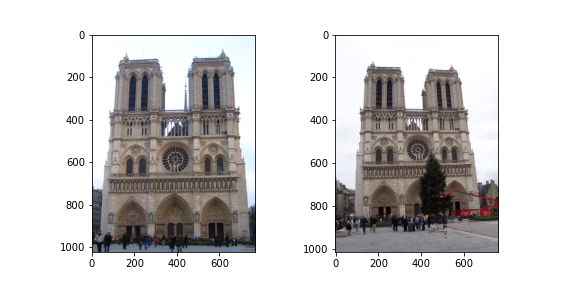

In [99]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from proj2_code.utils import load_image, PIL_resize, rgb2gray, normalize_img, verify
from IPython.core.debugger import set_trace

# Notre Dame
image1 = load_image('../data/1a_notredame.jpg')
image2 = load_image('../data/1b_notredame.jpg')
eval_file = '../ground_truth/notredame.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/2a_rushmore.jpg')
# image2 = load_image('../data/2b_rushmore.jpg')
# eval_file = '../ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('../data/3a_gaudi.jpg')
# image2 = load_image('../data/3b_gaudi.jpg')
# eval_file = '../ground_truth/gaudi.pkl'

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)


# Part 1: Harris Corner Detector 
## Find distinctive points in each image (Szeliski 4.1.1)

The Harris corner detector and SIFT rely heavily upon image gradient information. You'll implement `compute_image_gradients()` and then we'll visualize the magnitude of the image gradients. Which areas have highest mangitude, and why?

compute_image_gradients():  "Correct"


<IPython.core.display.Javascript object>


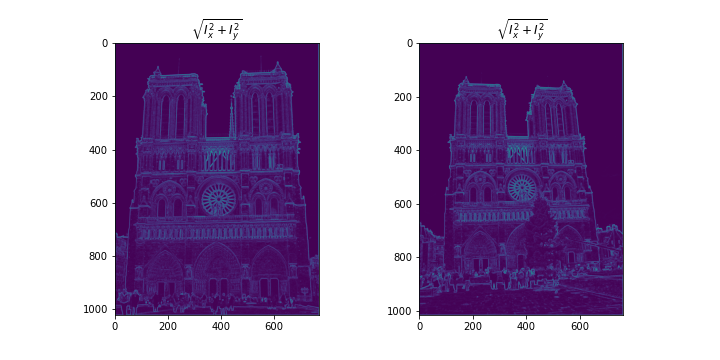

In [100]:
from proj2_code.part1_harris_corner import compute_image_gradients
from proj2_unit_tests.test_part1_harris_corner import test_compute_image_gradients

print('compute_image_gradients(): ', verify(test_compute_image_gradients))

plt.figure(figsize=(10,5))
plt.axis('off')

Ix, Iy = compute_image_gradients(image1_bw)

gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,1)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

Ix, Iy = compute_image_gradients(image2_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,2)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))


We'll now compute the second moments $s_x^2, s_y^2, s_x s_y$ at each pixel, which aggregates gradient information in local neighborhoods. We'll use a 2d Gaussian filter to aggregate:

In [128]:
from proj2_code.part1_harris_corner import second_moments

from proj2_unit_tests.test_part1_harris_corner import (
    test_get_gaussian_kernel_2D_pytorch_peak,
    test_get_gaussian_kernel_2D_pytorch_sumsto1,
    test_get_gaussian_kernel_2D_pytorch,
    test_second_moments
)

print('get_gaussian_kernel_2D_pytorch_peak():', verify(test_get_gaussian_kernel_2D_pytorch_peak))
print('get_gaussian_kernel_2D_pytorch_sumsto1():', verify(test_get_gaussian_kernel_2D_pytorch_sumsto1))
print('get_gaussian_kernel_2D_pytorch():', verify(test_get_gaussian_kernel_2D_pytorch))
print('second_moments():', verify(test_second_moments))

sx2, sy2, sxsy = second_moments(image1_bw, ksize = 7, sigma = 10)

get_gaussian_kernel_2D_pytorch_peak(): "Correct"
get_gaussian_kernel_2D_pytorch_sumsto1(): "Correct"
get_gaussian_kernel_2D_pytorch(): "Correct"
second_moments(): "Correct"


If we compare $s_x^2$, $s_y^2$, and $s_x s_y$ with $I_x$ and $I_y$, we see:

<IPython.core.display.Javascript object>


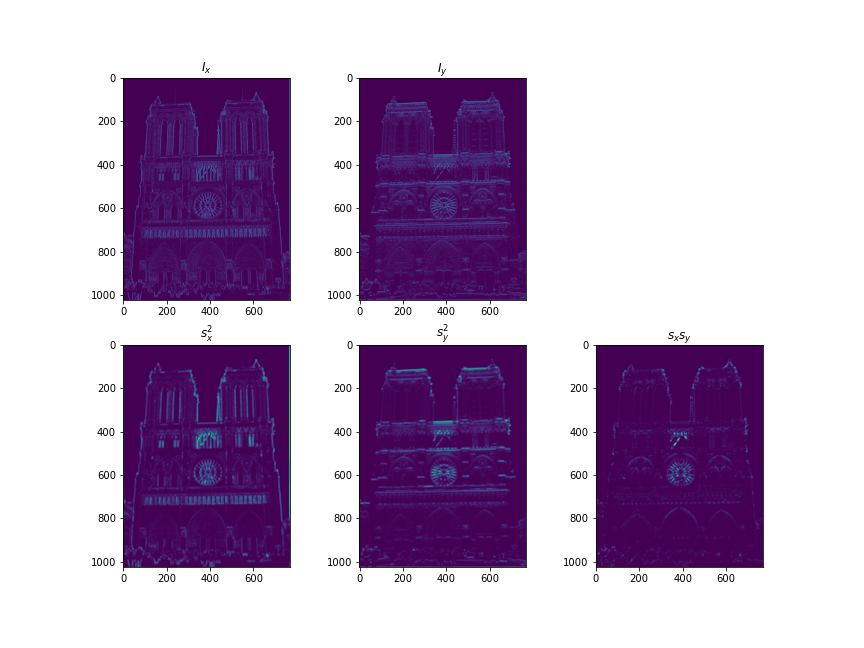

In [129]:
from proj2_code.utils import normalize_img

plt.figure(figsize=(12,9))
Ix, Iy = compute_image_gradients(image1_bw)
plt.subplot(2,3,1); plt.title(r'$I_x$')
plt.imshow( (normalize_img(np.abs(Ix))*255).astype(np.uint8))
plt.subplot(2,3,2); plt.title(r'$I_y$')
plt.imshow( (normalize_img(np.abs(Iy))*255).astype(np.uint8))

plt.subplot(2,3,4)
plt.title(r'$s_x^2$')
plt.imshow( (normalize_img(np.abs(sx2))*255).astype(np.uint8))

plt.subplot(2,3,5)
plt.title(r'$s_y^2$')
plt.imshow( (normalize_img(np.abs(sy2))*255).astype(np.uint8))

plt.subplot(2,3,6)
plt.title(r'$s_xs_y$')
plt.imshow( (normalize_img(np.abs(sxsy))*255).astype(np.uint8))

Note that $s_xs_y$ is highest where there are both strong x-direction and y-direction gradients (corners and the central rose window).

We'll now use these second moments to compute a "cornerness score" -- a corner response map -- as a function of these image gradients.

compute_harris_response_map():  "Correct"


<IPython.core.display.Javascript object>


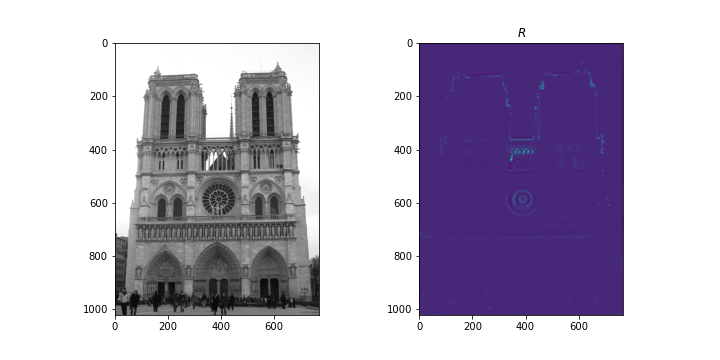

In [136]:
from proj2_code.part1_harris_corner import compute_harris_response_map
from proj2_unit_tests.test_part1_harris_corner import test_compute_harris_response_map

print('compute_harris_response_map(): ', verify(test_compute_harris_response_map))

R = compute_harris_response_map(image1_bw)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image1_bw, cmap='gray')
plt.subplot(1,2,2)
plt.title(r'$R$')
plt.imshow(R)

The bright areas above are the areas of highest "corners".

We'll now implement non-max suppression to find local maxima in the 2d response map. One simple way to do non-maximum suppression is to simply pick a local maximum over some window size (u, v). This can be achieved using max-pooling.

maxpool_numpy():  "Correct"


<IPython.core.display.Javascript object>


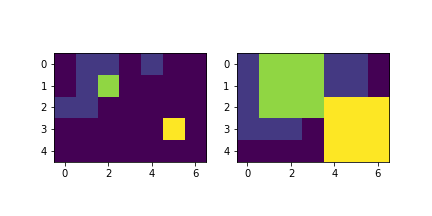

In [236]:
from proj2_code.part1_harris_corner import maxpool_numpy
from proj2_unit_tests.test_part1_harris_corner import test_maxpool_numpy, test_nms_maxpool_pytorch
from proj2_code.utils import verify

print('maxpool_numpy(): ', verify(test_maxpool_numpy))

toy_response_map = np.array(
[
        [1,2,2,1,2,1,1],
        [1,2,6,1,1,1,1],
        [2,2,1,1,1,1,1],
        [1,1,1,1,1,7,1],
        [1,1,1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(toy_response_map.astype(np.uint8))

plt.subplot(1,2,2)
maxpooled_image = maxpool_numpy(toy_response_map, ksize=3)
plt.imshow(maxpooled_image.astype(np.uint8))

Given a simple 5x5 grid of response scores, non-max suppression will allow us to choose values that are local maxima. If we request the top $k=2$ responses of the toy response grid above, we should get (1,1) and (3,3)

In [237]:
from proj2_code.part1_harris_corner import nms_maxpool_pytorch

print('nms_maxpool_pytorch(): ', verify(test_nms_maxpool_pytorch))

x_coords, y_coords, confidences = nms_maxpool_pytorch(toy_response_map, k=2, ksize=3)
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')

[3 1] [5 2]
nms_maxpool_pytorch():  "Correct"
Coordinates of local maxima:
	At 3,5, local maximum w/ confidence=7.00
	At 1,2, local maximum w/ confidence=6.00


Here we will call the `get_harris_interest_points()` function in `part1_harris_corner.py` to detect 'interesting' points in the images. 

**IMPORTANT**
Make sure to add your code in the `get_harris_interest_points()` function to call Harris Corner Detector.

In [238]:
from proj2_unit_tests.test_part1_harris_corner import test_get_harris_interest_points, test_remove_border_vals

print('test_remove_border_vals(): ', verify(test_remove_border_vals))

print('get_harris_interest_points()', verify(test_get_harris_interest_points))

test_remove_border_vals():  "Correct"
[9]
[9]
[1.]
get_harris_interest_points() "Correct"


<IPython.core.display.Javascript object>


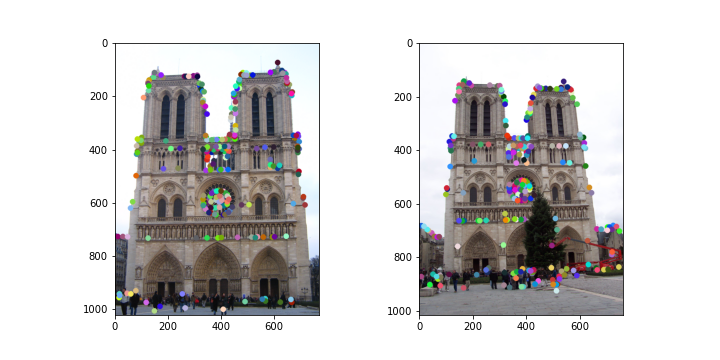

2462 corners in image 1, 2453 corners in image 2


In [242]:
import copy
from proj2_code.part1_harris_corner import get_harris_interest_points
from proj2_code.utils import show_interest_points

num_interest_points = 2500
X1, Y1, C1 = get_harris_interest_points( copy.deepcopy(image1_bw), num_interest_points)
X2, Y2, C2 = get_harris_interest_points( copy.deepcopy(image2_bw), num_interest_points)

num_pts_to_visualize = 250
# Visualize the interest points
rendered_img1 = show_interest_points(image1, Y1[:num_pts_to_visualize], X1[:num_pts_to_visualize])
#rendered_img1 = show_interest_points(image1, np.array([X1[10]]), np.array([Y1[10]]))
rendered_img2 = show_interest_points(image2, Y2[:num_pts_to_visualize], X2[:num_pts_to_visualize])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rendered_img1)
plt.subplot(1,2,2); plt.imshow(rendered_img2)
print(f'{len(X1)} corners in image 1, {len(X2)} corners in image 2')

# Part 2: Normalized Patch Feature Descriptor
## Create feature vectors at each interest point (Szeliski 7.1.2, page 414)
Perhaps the simplest possible keypoint descriptor is to stack the 16x16 patch surrounding the keypoint into a 256-dimensional vector, and normalize it.

[7 8] [7 8]
compute_normalized_patch_descriptors: "Correct"
[408 410 439 ... 507 873 926] [411 395 346 ... 179 169 102]
[394 393 393 ... 309 919 926] [344 371 398 ... 245 571 330]


<IPython.core.display.Javascript object>


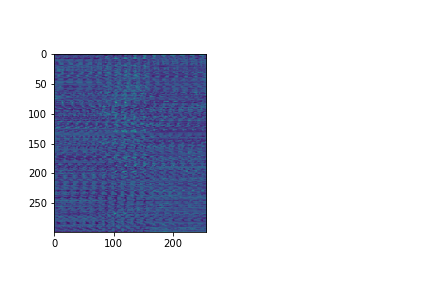

244 438
(1024, 768)


<IPython.core.display.Javascript object>


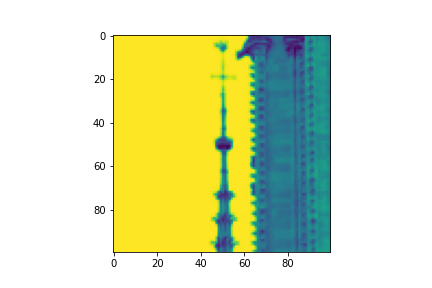

In [243]:
from proj2_code.part2_patch_descriptor import compute_normalized_patch_descriptors
from proj2_unit_tests.test_part2_patch_descriptor import test_compute_normalized_patch_descriptors

print('compute_normalized_patch_descriptors:', verify(test_compute_normalized_patch_descriptors))

image1_features = compute_normalized_patch_descriptors(image1_bw, X1, Y1, feature_width=16)
image2_features = compute_normalized_patch_descriptors(image2_bw, X2, Y2, feature_width=16)

# Visualize what the first 300 feature vectors for image 1 look like (they should not be identical or all black)
plt.figure()
plt.subplot(1,2,1); plt.imshow(image1_features[:300])

#print(image1_features[157])
xd = X1[10]
yd = Y1[10]
print(xd,yd)
print(np.shape(image1_bw))
plt.figure()
plt.imshow(image1_bw[xd-50:xd+50,yd-50:yd+50])

## Part 3: Match features (Szeliski 7.1.3, page 421)

In [244]:
#test your feature matching implementation
from proj2_unit_tests.test_part3_feature_matching import (
    test_match_features_ratio_test,
    test_compute_feature_distances_2d,
    test_compute_feature_distances_10d
)

print('compute_feature_distances (2d):', verify(test_compute_feature_distances_2d))
print('compute_feature_distances (10d):', verify(test_compute_feature_distances_10d))
print('match_features_ratio_test:', verify(test_match_features_ratio_test))

(3, 4)
(3, 2)
0 [-2  0]
1 [2 0]
2 [4 0]
compute_feature_distances (2d): "Correct"
(2, 2)
(2, 10)
0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
compute_feature_distances (10d): "Correct"
(2, 2)
(2, 2)
[[0 1]]
[0.4472136]
[[0 1]]
match_features_ratio_test: "Correct"


In [245]:
from proj2_code.part3_feature_matching import match_features_ratio_test

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

(2462, 2453)
(2462, 256)
105 matches from 2462 corners


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

<IPython.core.display.Javascript object>


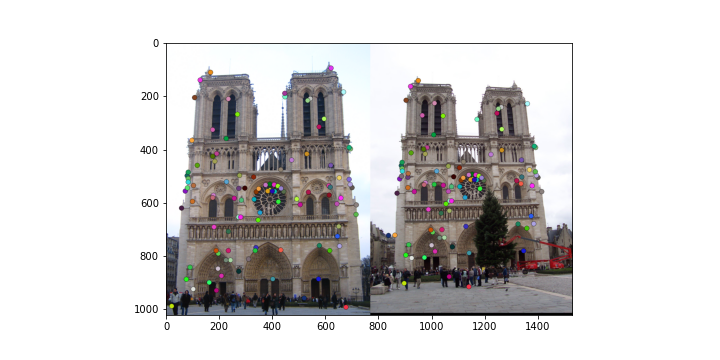

C:\Users\prana\anaconda3\envs\cs6476_proj2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


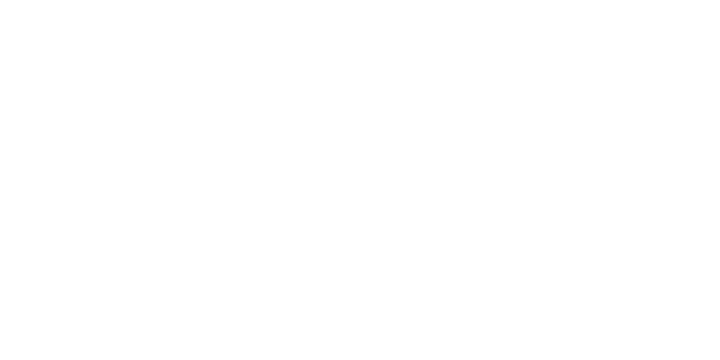

In [248]:
import os
from proj2_code.utils import show_correspondence_circles, show_correspondence_lines
os.makedirs('../results', exist_ok=True)
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 200
c1 = show_correspondence_circles(image1, image2,
                    Y1[matches[:num_pts_to_visualize, 0]], X1[matches[:num_pts_to_visualize, 0]],
                    Y2[matches[:num_pts_to_visualize, 1]], X2[matches[:num_pts_to_visualize, 1]])
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    Y1[matches[:num_pts_to_visualize, 0]], X1[matches[:num_pts_to_visualize, 0]],
                    Y2[matches[:num_pts_to_visualize, 1]], X2[matches[:num_pts_to_visualize, 1]])
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)
plt.close()

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  

You found 105/100 required matches
Accuracy = 0.752381


C:\Users\prana\anaconda3\envs\cs6476_proj2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


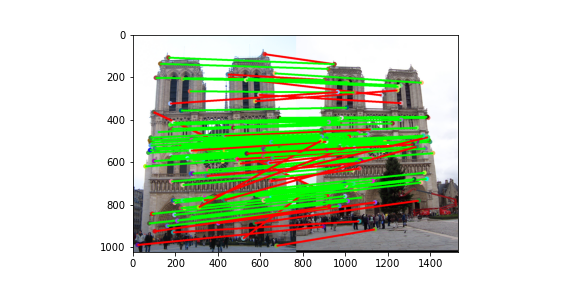

In [250]:
from proj2_code.utils import evaluate_correspondence
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 2500
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        Y1[matches[:num_pts_to_evaluate, 0]], X1[matches[:num_pts_to_evaluate, 0]],
                        Y2[matches[:num_pts_to_evaluate, 1]], X2[matches[:num_pts_to_evaluate, 1]])
plt.figure(figsize=(8,4)); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)

# Part 4: Sift Feature Descriptor (Szeliski 7.1.2, page 416)
SIFT relies upon computing the magnitudes and orientations of image gradients, and then computing weighted histograms.

In [251]:
from proj2_unit_tests.test_part4_sift_descriptor import (
    test_get_magnitudes_and_orientations,
    test_get_gradient_histogram_vec_from_patch
)
print('get_magnitudes_and_orientations:', verify(test_get_magnitudes_and_orientations))

get_magnitudes_and_orientations: "Correct"


In [252]:
print('get_gradient_histogram_vec_from_patch():', verify(test_get_gradient_histogram_vec_from_patch))

TypeError: get_gradient_histogram_vec_from_patch() missing 1 required positional argument: 'gaussian'

In [253]:
from proj2_unit_tests.test_part4_sift_descriptor import test_get_feat_vec, test_get_SIFT_descriptors
print(verify(test_get_feat_vec))
print(verify(test_get_SIFT_descriptors))

"Correct"
"Correct"


SIFT took 4.9966349601745605 sec.


<IPython.core.display.Javascript object>


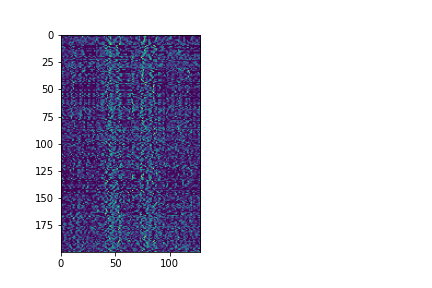

In [254]:
from proj2_code.part4_sift_descriptor import get_SIFT_descriptors
from proj2_code.utils import cheat_interest_points

import time
start = time.time()
image1_features = get_SIFT_descriptors(image1_bw, X1, Y1)
image2_features = get_SIFT_descriptors(image2_bw, X2, Y2)
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

# visualize what the values of the first 200 SIFT feature vectors look like (should not be identical or all black)
plt.figure(); plt.subplot(1,2,1); plt.imshow(image1_features[:200])

(2462, 2453)
(2462, 128)
198 matches from 2462 corners


<IPython.core.display.Javascript object>


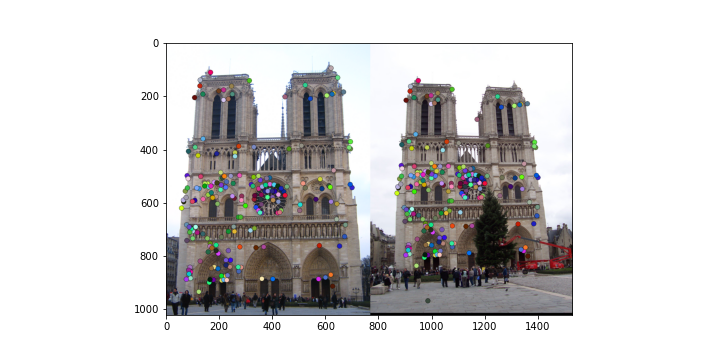

<IPython.core.display.Javascript object>


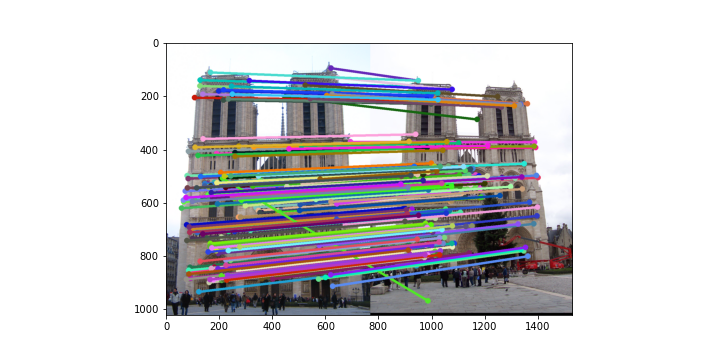

In [255]:
from proj2_code.utils import show_correspondence_circles, show_correspondence_lines

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 200
c1 = show_correspondence_circles(
    image1,
    image2,
    Y1[matches[:num_pts_to_visualize, 0]],
    X1[matches[:num_pts_to_visualize, 0]],
    Y2[matches[:num_pts_to_visualize, 1]],
    X2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(
    image1,
    image2,
    Y1[matches[:num_pts_to_visualize, 0]],
    X1[matches[:num_pts_to_visualize, 0]],
    Y2[matches[:num_pts_to_visualize, 1]],
    X2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)

You found 198/100 required matches
Accuracy = 0.924242


<IPython.core.display.Javascript object>


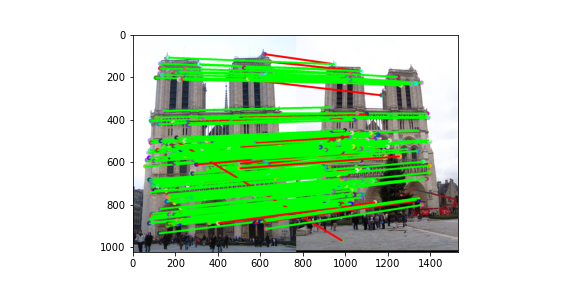

In [256]:
from proj2_code.utils import evaluate_correspondence
num_pts_to_evaluate = len(matches)
_, c = evaluate_correspondence(
    image1,
    image2,
    eval_file,
    scale_factor,
    Y1[matches[:num_pts_to_evaluate, 0]],
    X1[matches[:num_pts_to_evaluate, 0]],
    Y2[matches[:num_pts_to_evaluate, 1]],
    X2[matches[:num_pts_to_evaluate, 1]]
)
plt.figure(figsize=(8,4)); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)

Ensure your code runs in under 90 sec and achieves >80% acc on the Notre Dame pair:

In [258]:
from proj2_unit_tests.test_part4_sift_descriptor import (
    test_feature_matching_speed,
    test_feature_matching_accuracy
)
print('SIFT pipeline speed test:', verify(test_feature_matching_speed))
print('SIFT pipeline accuracy test:', verify(test_feature_matching_accuracy))

(2462, 2453)
(2462, 128)
198 matches from 2462 corners
Your Feature matching pipeline takes 14.16 seconds to run on Notre Dame
SIFT pipeline speed test: "Correct"
(2462, 2453)
(2462, 128)
You found 198/100 required matches
Accuracy = 0.924242
Your Feature matching pipeline achieved 92.42% accuracy to run on Notre Dame
SIFT pipeline accuracy test: "Correct"


# Optional Extra Credit
Implement SIFT in a fully vectorized manner with at least 80% accuracy on Notre Dame (With no loops over pixels, but at most a loop over keypoints). SIFT on both images should run in under 5 seconds combined. Orientation at each vector can be obtained via 1x1 convolution with 8 unit vector basis vectors.

In [ ]:
import time
from proj2_code.part4_sift_descriptor import get_sift_features_vectorized

start = time.time()
image1_features = get_sift_features_vectorized(image1_bw, X1, Y1)
image2_features = get_sift_features_vectorized(image2_bw, X2, Y2)
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

matches, confidences = match_features_ratio_test(image1_features, image2_features)

num_pts_to_evaluate = len(matches) - 1
_, c = evaluate_correspondence(
    image1,
    image2,
    eval_file,
    scale_factor,
    X1[matches[:, 0]],
    Y1[matches[:, 0]],
    X2[matches[:, 1]],
    Y2[matches[:, 1]]
)
plt.figure(figsize=(8,4)); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)

In [ ]:
from proj2_unit_tests.test_part4_sift_descriptor import test_extra_credit_vectorized_sift

print(verify(test_extra_credit_vectorized_sift))